In [122]:
pip install gpflow tensorflow~=2.10.0 tensorflow-probability~=0.18.0

In [123]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.dates as mdates
import numpy as np
import os
import gpflow
import warnings
warnings.filterwarnings('ignore')

In [178]:
df = pd.read_csv('MSN.csv', index_col ="Date/Time")
df.head()

,Ticker,Open,High,Low,Close,Volume,Open Interest
Date/Time,,,,,,,
12/25/2017 9:15,MSN,73.1,73.1,73.1,73.1,4210,0
12/25/2017 9:16,MSN,73.0,73.0,73.0,73.0,5000,0
12/25/2017 9:18,MSN,73.5,73.5,73.5,73.5,210,0
12/25/2017 9:20,MSN,73.2,73.5,73.1,73.1,2050,0
12/25/2017 9:21,MSN,73.0,73.0,73.0,73.0,1380,0


In [179]:
df = df.iloc[:, 4:5]
df = df.dropna()
df.index = pd.to_datetime(df.index)
df['Day'] = df.index.day
df['Year'], df['Month'] = df.index.year, df.index.month
df = df.resample('12H').mean().dropna()
df.head()

,Close,Day,Year,Month
Date/Time,,,,
2017-12-25 00:00:00,73.492308,25.0,2017.0,12.0
2017-12-25 12:00:00,74.087755,25.0,2017.0,12.0
2017-12-26 00:00:00,74.866667,26.0,2017.0,12.0
2017-12-26 12:00:00,74.924561,26.0,2017.0,12.0
2017-12-27 00:00:00,75.274026,27.0,2017.0,12.0


## Log-returns

In [180]:
df['log_returns'] = np.log(df.Close).diff()
df.dropna(inplace=True)

In [181]:
index = np.array([])
for year in df['Year'].unique():
    close = df.Close[df['Year'] == year]
    index = np.append(index, range(0, len(close)))
df['Index'] = index

In [183]:
start_train = '2017-12-25'
end_train = '2020-01-31'
df_train = df[(df.index >= start_train) & (df.index <= end_train)].iloc[:, :]
df_train.head()

,Close,Day,Year,Month,log_returns,Index
Date/Time,,,,,,
2017-12-25 12:00:00,74.087755,25.0,2017.0,12.0,0.008070,0.0
2017-12-26 00:00:00,74.866667,26.0,2017.0,12.0,0.010458,1.0
2017-12-26 12:00:00,74.924561,26.0,2017.0,12.0,0.000773,2.0
2017-12-27 00:00:00,75.274026,27.0,2017.0,12.0,0.004653,3.0
2017-12-27 12:00:00,75.300000,27.0,2017.0,12.0,0.000345,4.0


In [184]:
X_train = np.array(df_train[['Year', 'Month', 'Day', 'Index']])
y_train = df_train.iloc[:, 4].values
len(X_train)

1036

In [185]:
start_predict = '2020-01-31'
end_predict = '2020-11-22'
df_predict = df[(df.index >= start_predict) & (df.index <= end_predict)]
df_predict.head()

,Close,Day,Year,Month,log_returns,Index
Date/Time,,,,,,
2020-01-31 00:00:00,50.745455,31.0,2020.0,1.0,0.008353,32.0
2020-01-31 12:00:00,50.828395,31.0,2020.0,1.0,0.001633,33.0
2020-02-03 00:00:00,46.838077,3.0,2020.0,2.0,-0.081759,34.0
2020-02-03 12:00:00,47.539535,3.0,2020.0,2.0,0.014865,35.0
2020-02-04 00:00:00,50.072222,4.0,2020.0,2.0,0.051905,36.0


In [186]:
X_predict = np.array(df_predict[['Year', 'Month', 'Day', 'Index']])
y_test = df_predict.iloc[:, 4].values
len(X_predict)

414

In [187]:
y_train.reshape(-1, 1).shape

(1036, 1)

In [188]:
print(gpflow.kernels.ChangePoints)

<class 'gpflow.kernels.changepoints.ChangePoints'>


In [189]:
model = gpflow.models.GPR((X_train, y_train.reshape(-1, 1)),
                          kernel = gpflow.kernels.Matern32())

opt = gpflow.optimizers.Scipy()
opt.minimize(model.training_loss, model.trainable_variables)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -3034.0889883073182
        x: [ 8.787e-02 -9.145e+00 -9.651e+00]
      nit: 30
      jac: [-1.505e-04 -1.511e-03 -8.766e-04]
     nfev: 44
     njev: 44
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [190]:
y_pred, y_var = model.predict_f(X_predict, full_cov = False)

In [191]:
y_lower = y_pred - 1.96 * np.sqrt(y_var)
y_upper = y_pred + 1.96 * np.sqrt(y_var)

### Visualization

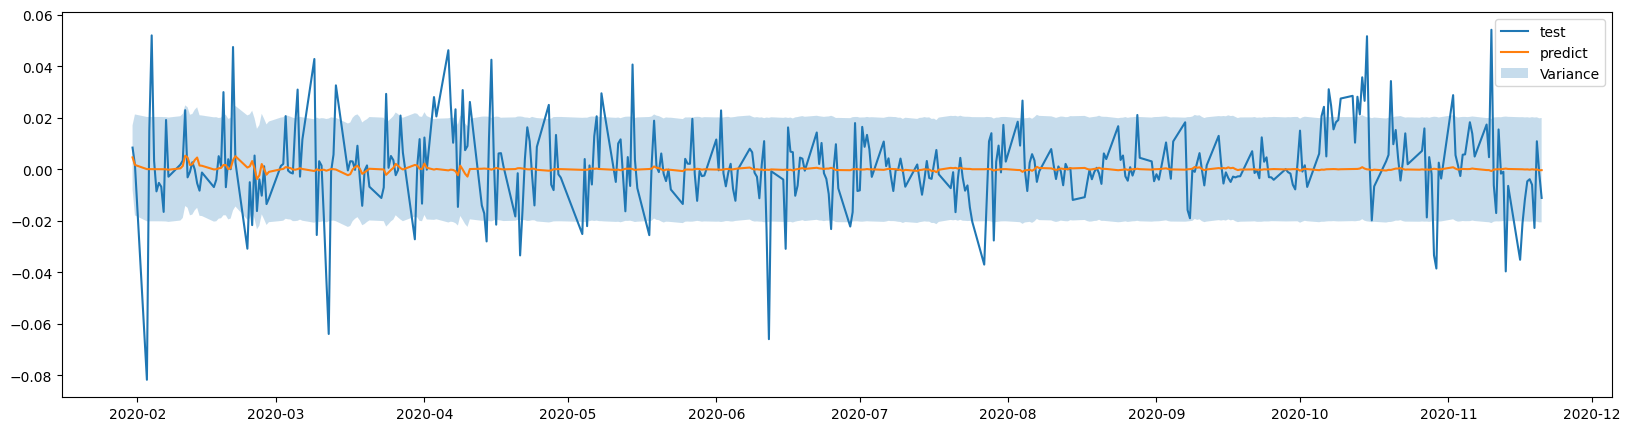

In [192]:
plt.figure(figsize=(20, 5))
plt.plot(df_predict.index, y_test, label = 'test')
plt.plot(df_predict.index, y_pred, label = 'predict')
plt.fill_between(df_predict.index, np.array(y_lower).squeeze(), np.array(y_upper).squeeze(), alpha = 0.25, label = 'Variance')
plt.legend()
plt.show()

## Volatility

In [205]:
df = pd.read_csv('MSN.csv', index_col ="Date/Time")
df.head()

,Ticker,Open,High,Low,Close,Volume,Open Interest
Date/Time,,,,,,,
12/25/2017 9:15,MSN,73.1,73.1,73.1,73.1,4210,0
12/25/2017 9:16,MSN,73.0,73.0,73.0,73.0,5000,0
12/25/2017 9:18,MSN,73.5,73.5,73.5,73.5,210,0
12/25/2017 9:20,MSN,73.2,73.5,73.1,73.1,2050,0
12/25/2017 9:21,MSN,73.0,73.0,73.0,73.0,1380,0


In [206]:
df = df.iloc[:, 4:5]
df = df.dropna()
df.index = pd.to_datetime(df.index)
df['Day'] = df.index.day
df['Year'], df['Month'] = df.index.year, df.index.month
df = df.resample('12H').mean().dropna()
df.head()

,Close,Day,Year,Month
Date/Time,,,,
2017-12-25 00:00:00,73.492308,25.0,2017.0,12.0
2017-12-25 12:00:00,74.087755,25.0,2017.0,12.0
2017-12-26 00:00:00,74.866667,26.0,2017.0,12.0
2017-12-26 12:00:00,74.924561,26.0,2017.0,12.0
2017-12-27 00:00:00,75.274026,27.0,2017.0,12.0


In [207]:
index = np.array([])
for year in df['Year'].unique():
    close = df.Close[df['Year'] == year]
    index = np.append(index, range(0, len(close)))
df['Index'] = index
df['vol_5'] = df['Close'].rolling(5).std()
df.dropna(inplace = True)
df

,Close,Day,Year,Month,Index,vol_5
Date/Time,,,,,,
2017-12-27 00:00:00,75.274026,27.0,2017.0,12.0,4.0,0.723702
2017-12-27 12:00:00,75.300000,27.0,2017.0,12.0,5.0,0.490130
2017-12-28 00:00:00,75.025000,28.0,2017.0,12.0,6.0,0.199201
2017-12-28 12:00:00,75.333333,28.0,2017.0,12.0,7.0,0.184157
2017-12-29 12:00:00,76.534146,29.0,2017.0,12.0,8.0,0.594496
...,...,...,...,...,...,...
2020-12-18 12:00:00,83.965556,18.0,2020.0,12.0,485.0,0.336383
2020-12-21 00:00:00,84.205738,21.0,2020.0,12.0,486.0,0.366189
2020-12-21 12:00:00,83.710345,21.0,2020.0,12.0,487.0,0.187106


In [208]:
start_train = '2017-12-25'
end_train = '2020-01-31'
df_train = df[(df.index >= start_train) & (df.index <= end_train)].iloc[:, :]
df_train.head()

,Close,Day,Year,Month,Index,vol_5
Date/Time,,,,,,
2017-12-27 00:00:00,75.274026,27.0,2017.0,12.0,4.0,0.723702
2017-12-27 12:00:00,75.300000,27.0,2017.0,12.0,5.0,0.490130
2017-12-28 00:00:00,75.025000,28.0,2017.0,12.0,6.0,0.199201
2017-12-28 12:00:00,75.333333,28.0,2017.0,12.0,7.0,0.184157
2017-12-29 12:00:00,76.534146,29.0,2017.0,12.0,8.0,0.594496


In [209]:
X_train = np.array(df_train[['Year', 'Month', 'Day', 'Index']])
y_train = df_train.iloc[:, 5].values
len(X_train)

1033

In [210]:
start_predict = '2020-01-31'
end_predict = '2020-11-22'
df_predict = df[(df.index >= start_predict) & (df.index <= end_predict)]
df_predict.head()

,Close,Day,Year,Month,Index,vol_5
Date/Time,,,,,,
2020-01-31 00:00:00,50.745455,31.0,2020.0,1.0,32.0,1.775491
2020-01-31 12:00:00,50.828395,31.0,2020.0,1.0,33.0,1.339111
2020-02-03 00:00:00,46.838077,3.0,2020.0,2.0,34.0,1.770135
2020-02-03 12:00:00,47.539535,3.0,2020.0,2.0,35.0,1.911982
2020-02-04 00:00:00,50.072222,4.0,2020.0,2.0,36.0,1.879932


In [211]:
X_predict = np.array(df_predict[['Year', 'Month', 'Day', 'Index']])
y_test = df_predict.iloc[:, 5].values
len(X_predict)

414

In [212]:
model = gpflow.models.GPR((X_train, y_train.reshape(-1, 1)),
                          kernel = gpflow.kernels.Matern32())

opt = gpflow.optimizers.Scipy()
opt.minimize(model.training_loss, model.trainable_variables)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 676.1696782373951
        x: [ 4.380e+00  1.855e+00 -6.801e+00]
      nit: 19
      jac: [-8.962e-05  1.939e-04 -8.269e-06]
     nfev: 23
     njev: 23
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [213]:
y_pred, y_var = model.predict_f(X_predict, full_cov = False)

In [214]:
y_lower = y_pred - 1.96 * np.sqrt(y_var)
y_upper = y_pred + 1.96 * np.sqrt(y_var)

### Visualization

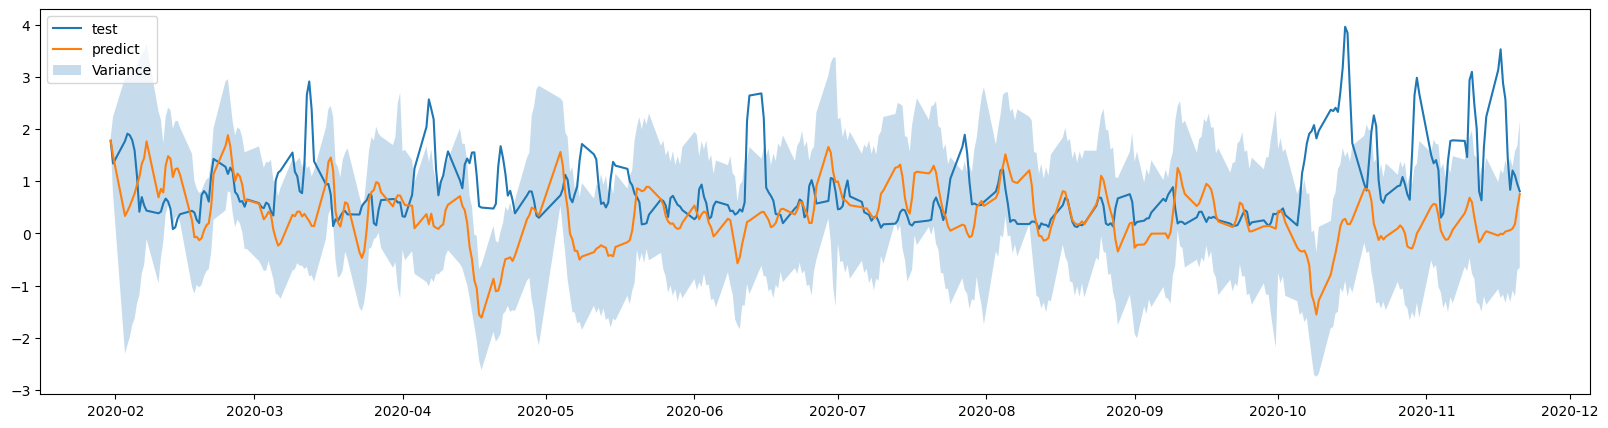

In [215]:
plt.figure(figsize=(20, 5))
plt.plot(df_predict.index, y_test, label = 'test')
plt.plot(df_predict.index, y_pred, label = 'predict')
plt.fill_between(df_predict.index, np.array(y_lower).squeeze(), np.array(y_upper).squeeze(), alpha = 0.25, label = 'Variance')
plt.legend()
plt.show()